# Webley's FVM Method 

In which I implement an FVM method described in Webley and He, 2000, *Fast Solution-adaptive finite volume method for PSA/VSA cycle simulation; 1 single-step simulation*.

In [217]:
#Call relevant libraries
using DifferentialEquations
using Plots
using Roots.fzero

#Define function for the ODE solver: this function will find dPdt and dy1dt, given P and y at each point. 
#Contained in this function will be all information about the discretisation of the domain, as well as
#physical properties of the system. We consider the case in which only one component is absorbed.
#It will itself depend on a number of external functions.
#We start by assuming that v > 0.
function dYdt(t,Y)
    (L,A,ρ_b,ɛ_b,R,T,N,Δ,P,y1,n1,n2,d_p) = DefineSystem(Y)
    vwallinterior = VelocityInteriorFunc(P,ρ_b,ɛ_b,d_p,N,Δ)
    (Pwallinterior,y1wallinterior) = WallValsInterior(P,)
    (Pwall,y1wall,vwall) = WallValsBC(Pwallinterior,y1wallinterior,n1wallinterior,vwallinterior)
    dYdt = maindYdt(Pwall,y1wall,vwall,P,y,n1,n2,Δ,ρ_b,ɛ_b,R,T,k1,k2,K1,K2)
    return dYdt
end

function ICs(N)
    P0 = zeros(N);    y10 = zeros(N);    n10 = zeros(N);    n20 = zeros(N);    
    for i = 1:N
        P0[i]  = 101.3
        y10[i] = 0.0
        n10[i] = 0.0
        n20[i] = 0.0
    end
    return [P0;y10;n10;n20]
end

#ode45(dYdt,ICs(N),(0.0,1.0))
    
function DefineSystem(Y)
    (L,A,ρ_b,ɛ_b,R,T,d_p) = (10,1,1000,0.5,8.314,300,1e-2)  #Bed Length (m), Bed Area (m2), Bulk Density (kg/m3), Bed Voidage, Gas Constant (J/K.mol), Temperature (K), Particle Diameter (m)
    N = 100                                            #Number of finite volumes
    Δ = L/N                                            #Cell Length
    P = Y[1:N]                                         #Pressures (Pa)
    y1= Y[N+1:2N]                                      #Concentrations
    n1= Y[2N+1:3N]                                     #Solid loading, mol/kg
    n2= Y[3N+1:4N]                                     #Solid loading, mol/kg
    μ_g1 = 1.8e-5; μ_g2 = 2.5e-5;                      #Viscosity of gases (Pa.s)
    ρ_g1 = 0.044*P/(R*T); ρ_g2 = 0.028*P/(R*T);        #Density of gases (numbers are molecular weights) (kg/m3)
    μ_g = y1*μ_g1 + (1-y1)*μ_g2                        #Mean viscosity of gas in each cell (Pa.s)
    ρ_g = y1.*ρ_g1 + (1-y1).*ρ_g2                      #Mean density of gas in each cell (kg/m3)
    return (L,A,ρ_b,ɛ_b,R,T,N,Δ,P,y1,n1,n2,d_p)
end

function VelocityInteriorFunc(P,ρ_b,ɛ_b,d_p,N,Δ,ρ_g,μ_g)
    vwall = zeros(N+1)
    dPdzinteriortemp = [0;[(P[i] - P[i-1])/Δ for i in 2:N];0]
    for i = 2:N
        ρ_gwall = (ρ_g[i]+ρ_g[i-1])/2; μ_gwall = (μ_g[i]+μ_g[i-1])/2;  #Density and viscosity at wall (kg/m3;Pa.s)
        f(u) = dPdzinteriortemp[i] + 1.75*(1-ɛ_b)*ρ_gwall/(ɛ_b*d_p)*u^2 + 12μ_gwall*(1-ɛ_b)^2/(ɛ^2d_p^2)*u  #Ergun Equation
        vwallinterior[i] = fzero(f,1.0)/ɛ_b        #Interstitial velocity at wall (m/s)
    end
    return vwallinterior
end
    
function WallValsInterior(P,y1,N,Δ,vwallinterior)
    Pwallinterior = zeros(N+1);   y1wallinterior = zeros(N+1);      
    #Assume v>0 Calculate rj values
    rP  = [0;[( P[j]- P[j-1])/( P[j+1]- P[j]) for j in 2:N-1];0]
    ry1 = [0;[(y1[j]-y1[j-1])/(y1[j+1]-y1[j]) for j in 2:N-1];0]
    Pwallquadinterior  = [0; P[1];[1/8*(3* P[j]+6* P[j-1]- P[j-2]) for j in 3:N];0]
    y1wallquadinterior = [0;y1[1];[1/8*(3*y1[j]+6*y1[j-1]-y1[j-2]) for j in 3:N];0]
    Pwallupinterior  = [0;[ P[j-1] for j in 2:N];0]
    y1wallupinterior = [0;[y1[j-1] for j in 2:N];0]
    K1 = 10; K2 = 1;
    for i = 2:N
        if rP[i] < 0
            Pwallinterior[i] = Pwallupinterior[i]
        elseif rP[i] < 5
            Pwallinterior[i] = (Pwallquadinterior[i] - Pwallupinterior[i])*(1-exp(-K1*rP[i])) + Pwallupinterior[i]
        elseif rP[i] < 10
            Pwallinterior[i] = (Pwallquadinterior[i] - Pwallupinterior[i])*exp(-K2*(rP[i]-5)) + Pwallupinterior[i]
        else
            Pwallinterior[i] = Pwallupinterior[i]
        end
    end
    for i = 2:N
        if ry1[i] < 0
            y1wallinterior[i] = y1wallupinterior[i]
        elseif ry1[i] < 5
            y1wallinterior[i] = (y1wallquadinterior[i] - y1wallupinterior[i])*(1-exp(-K1*ry1[i])) + y1wallupinterior[i]
        elseif ry1[i] < 10
            y1wallinterior[i] = (y1wallquadinterior[i] - y1wallupinterior[i])*exp(-K2*(ry1[i]-5)) + y1wallupinterior[i]
        else
            y1wallinterior[i] = y1wallupinterior[i]
        end
    end
    return (Pwallinterior,y1wallinterior)
end


function WallValsBC(P,y1,Pwallinterior,y1wallinterior,vwallinterior,A,ɛ_b,ρ_g,μ_g,d_p,Δ,L,N)
    #I'm going to model a simple system, with constant concentration and volumetric flow rate at the inlet,
    #and constant pressure at the outlet.
    y1in = 0.2;  #Inlet mole fraction
    Qin = 1;       #Inlet volumetric flow rate, m3/s
    Pout = 101300  #Outlet Pressure, Pa
    y1wall = y1wallinterior; Pwall = Pwallinterior; vwall = vwallinterior;
    
    #Inlet Conditions - constant volume
    y1wall[1] = y1in
    vwall[1] = Qin/(A*ɛ_b)
    dPdzinlet = -(1.75*(1-ɛ_b)*ρ_g[1]/(ɛ_b*d_p)*vwallinterior[1]^2*ɛ_b^2 + 12μ_g[1]*(1-ɛ_b)^2/(ɛ^2d_p^2)*vwallinterior*ɛ_b)
    Pwall[1] = P[1] - Δ/2 * dPdzinlet
    
    #Outlet Conditions - constant pressure
    Pwall[N+1] = Pout
    dPdzoutlet = (Pout - P[N])/(Δ/2)
    f(u) = dPdzoutlet + 1.75*(1-ɛ_b)*ρ_g[N]/(ɛ_b*d_p)*u^2 + 12μ_g[N]*(1-ɛ_b)^2/(ɛ^2d_p^2)*u  #Ergun Equation
    vwall[N+1] = fzero(f,1.0)/ɛ_b        #Interstitial velocity at wall (m/s)
    #Use Lagrange interpolant for y values.
    xvalsforLagrangeInterpolant = N*[Δ-2.5,Δ-1.5,Δ-0.5]
    yvalsforLagrangeInterpolant = [y1[N-2],y1[N-1],y1[N]]
    y1interpolant = LagrangeInterpolantGeneratorenerator(xvalsforLagrangeInterpolant,yvalsforLagrangeInterpolant)
    y1wall[N+1] = y1interpolant(L)
    return (Pwall,y1wall,vwall)
end

#Isotherm Function for n1eq and n2eq
function neqfunc(y1,K1,K2)
    return [y1*K1,(1-y1)*K2]
end

#LDF model for dn1dt and dn2dt
function dndtfunc(y1,n1,n2,k1,k2,K1,K2)
    (n1eq,n2eq) = neqfunc(y1,K1,K2)
    return [k1*(n1eq-n1),k2*(n2eq-n2)]
end

function maindYdt(Pwall,y1wall,vwall,P,y,n1,n2,Δ,ρ_b,ɛ_b,R,T,k1,k2,K1,K2)
    dPdt = zeros(N);    dy1dt = zeros(N);    dn1dt = zeros(N);    dn2dt = zeros(N);
    for i = 1:N
        (dn1dt[i],dn2dt[i]) = dndtfunc(y1[i],n1,n2,k1,k2,K1,K2)
        dPdt[i]  = 1/Δ(vwall[i-1]*Pwall[i-1]-vwall[i]*Pwall[i]) - ρ_b*R*T/ɛ_b*(dn1dt[i]+dn2dt[i])
        dy1dt[i] = 1/(ΔP[i])*(vwall[i-1]*Pwall[i-1]*y[i-1]-vwall[i]*Pwall[i]*y[i]) - ρ_b*R*T/ɛ_b*(dn1dt[i]) - y1[i]/P[i]*dPdt[i]
    end
    return [dPdt;dy1dt;dn1dt;dn2dt]
end

#This function, which could be handy in other contexts, returns another function, which is the Lagrange Interpolant
#of the values xvals and yvals.
function LagrangeInterpolantGenerator(xvals,yvals)
    function LagrangeInterpolant(x)
        numvalstoevaluate = length(x)
        numvalstoevaluate == 1 ? output = 0 : output = zeros(numvalstoevaluate)
        for k = 1:numvalstoevaluate
            N = length(xvals)
            LagrangePolynomials = ones(N)
            for i in 1:N  
                for j in [1:i-1;i+1:N]     #Surprisingly, this works even in the i=1 and i=N cases.
                    LagrangePolynomials[i] = LagrangePolynomials[i].*(x[k]-xvals[j])./(xvals[i]-xvals[j])
                end
            end
            numvalstoevaluate == 1 ? output = sum(LagrangePolynomials.*yvals) : output[k] = sum(LagrangePolynomials.*yvals)
        end
        return output
    end
    return LagrangeInterpolant
end

LagrangeInterpolantGenerator (generic function with 1 method)

In [25]:
[1;2,3].*[4,5,6]

3-element Array{Int64,1}:
  4
 10
 18

In [26]:
[1;2;3].*[4;5;6]

3-element Array{Int64,1}:
  4
 10
 18

In [6]:
a = 1
b = 2
c = 3

a>0 ? (b>3 ? d = 4 : d = 5) : d = 2

5

In [7]:
d

5

In [8]:
Pkg.add("Interpolations")

INFO: Cloning cache of AxisAlgorithms from https://github.com/timholy/AxisAlgorithms.jl.git
INFO: Cloning cache of Interpolations from https://github.com/JuliaMath/Interpolations.jl.git
INFO: Cloning cache of Ratios from https://github.com/timholy/Ratios.jl.git
INFO: Cloning cache of ShowItLikeYouBuildIt from https://github.com/JuliaArrays/ShowItLikeYouBuildIt.jl.git
INFO: Cloning cache of WoodburyMatrices from https://github.com/timholy/WoodburyMatrices.jl.git
INFO: Installing AxisAlgorithms v0.1.6
INFO: Installing Interpolations v0.5.0
INFO: Installing Ratios v0.0.4
INFO: Installing ShowItLikeYouBuildIt v0.0.1
INFO: Installing WoodburyMatrices v0.2.2
INFO: Package database updated
INFO: METADATA is out-of-date — you may not have the latest version of Interpolations
INFO: Use `Pkg.update()` to get the latest versions of your packages


In [13]:
f(x) = x^2
fold(x) = 1
for i = 1:10
    fold(x) = f(x)
    f(x) = fold(x) + 1
end
fold(3.0)

LoadError: StackOverflowError:

In [4]:
using Plots

In [31]:

itp = interpolate(([1,2,3,4,7],),[1;2;3;4;5],Gridded(Linear()))


5-element interpolate((::Array{Int64,1},), ::Array{Int64,1}, Gridded(Linear())) with element type Float64:
 1.0    
 2.0    
 3.0    
 4.0    
 4.33333

In [38]:
itp[9]

5.666666666666667

In [22]:
([1.0;2;3;5;9],)

([1.0,2.0,3.0,5.0,9.0],)

In [24]:
[1;2;3;4;5]

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

In [39]:
using ApproxFun

In [41]:
f = Fun(identity,0..1)

Fun(Chebyshev(【0.0,1.0】),[0.5,0.5])

In [14]:
i = 1

1

In [18]:
"This is a $i"

"This is a 1"

In [37]:
xvals = [1,2,3]; yvals = [2,5,8]
function l1(x)
    temp = ones(length(x))
    for i = [1,2]
        temp = temp.*(x-xvals[i])./(xvals[3]-xvals[i])
    end
    return temp
end



l1 (generic function with 1 method)


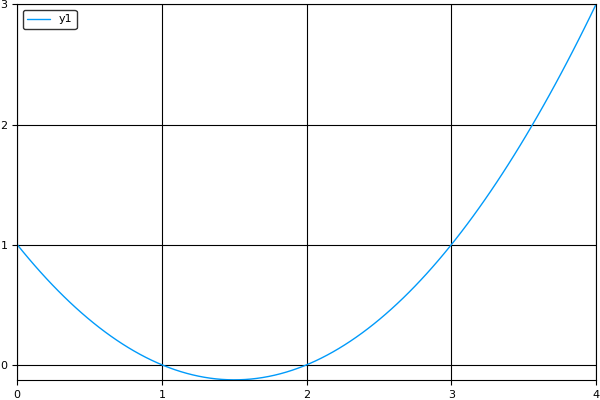

In [38]:
vals = linspace(0,4,100);
plot(vals,l1(vals))

In [34]:
l1(2.5)

1-element Array{Float64,1}:
 Inf

In [79]:
function LagrangeInterpolant(xvals,yvals)
    function tester(x)
        N = length(xvals)
        LagrangePolynomials = ones(N)
        for i in 1:N  
            for j in [1:i-1;i+1:N]     #Surprisingly, this works even in the i=1 and i=N cases.
                LagrangePolynomials[i] = LagrangePolynomials[i].*(x-xvals[i])./(xvals[j]-xvals[i])
            end
        end
        return LagrangePolynomials
    end
    return tester(x)
end

LagrangeInterpolant (generic function with 1 method)

In [127]:
xvals = [1,2,3]; yvals = [2,5,7]
function tester3(x)
    N = length(xvals)
    LagrangePolynomials = ones(N)
    for i in 1:N  
        for j in [1:i-1;i+1:N]     #Surprisingly, this works even in the i=1 and i=N cases.
            LagrangePolynomials[i] = LagrangePolynomials[i].*(x-xvals[j])./(xvals[j]-xvals[i])
        end
    end
    return sum(LagrangePolynomials.*yvals)
end


tester3 (generic function with 1 method)

In [195]:
x = linspace(0,10,3); sinx = sin(x);
a = LagrangeInterpolantGenerator(x,sin(x))

(::LagrangeInterpolant) (generic function with 1 method)


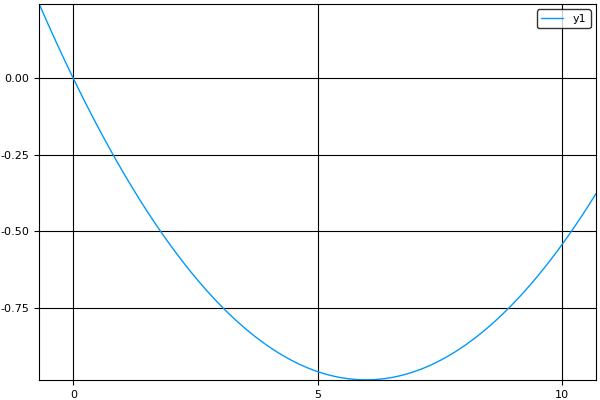

In [196]:
xx = linspace(-0.7,10.7,500)
plot(xx,a(xx))

In [80]:
a = LagrangeInterpolant([1,2,3],[2,5,8])

LoadError: UndefVarError: x not defined

In [112]:
function test(x1)
    function y(x)
        return x1 + x
    end
    return y
end

test (generic function with 1 method)

In [113]:
a = test(3)

(::y) (generic function with 1 method)

In [115]:
a(4)

7

In [65]:
i = 1; N = 6
[1:i-1;i+1:N]

5-element Array{Int64,1}:
 2
 3
 4
 5
 6

In [158]:
function LagrangeInterpolantGenerator(xvals,yvals)
    function LagrangeInterpolant(x)
        numvalstoevaluate = length(x)
        numvalstoevaluate == 1 ? output = 0 : output = zeros(numvalstoevaluate)
        for k = 1:numvalstoevaluate
            N = length(xvals)
            LagrangePolynomials = ones(N)
            for i in 1:N  
                for j in [1:i-1;i+1:N]     #Surprisingly, this works even in the i=1 and i=N cases.
                    LagrangePolynomials[i] = LagrangePolynomials[i].*(x[k]-xvals[j])./(xvals[j]-xvals[i])
                end
            end
            numvalstoevaluate == 1 ? output = sum(LagrangePolynomials.*yvals) : output[k] = sum(LagrangePolynomials.*yvals)
        end
        return output
    end
    return LagrangeInterpolant
end


LagrangeInterpolantGenerator (generic function with 1 method)

In [164]:
a = LagrangeInterpolantGenerator([1,2,3],[2,5,11])

(::LagrangeInterpolant) (generic function with 1 method)


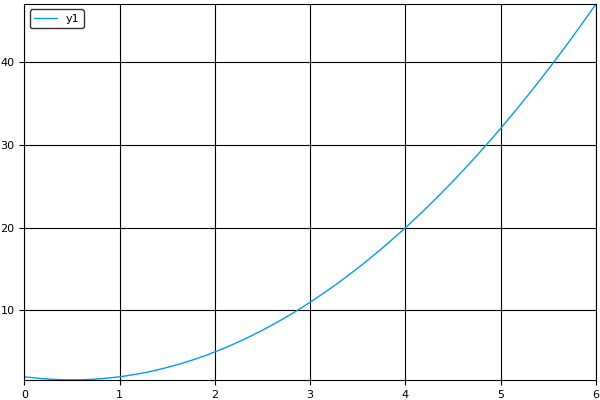

In [165]:
x = linspace(0,6,100)
plot(x,a(x))

In [167]:
function test()
    return 1
end

test (generic function with 2 methods)

In [170]:
a = test()
a

1

In [171]:
a

1


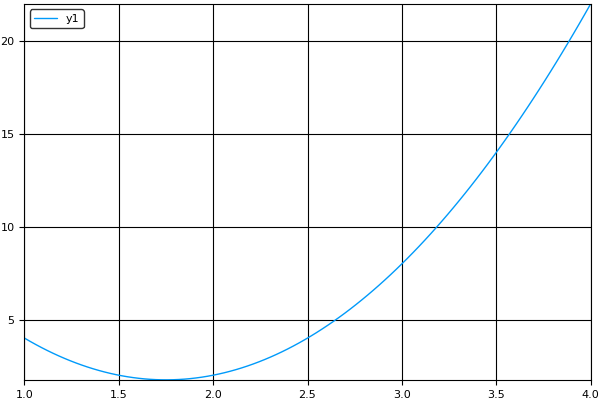

In [235]:

#This function returns another function, which is the Lagrange Interpolant of the values xvals and yvals.
function LagrangeInterpolantGenerator(xvals,yvals)
    function LagrangeInterpolant(x)
        numvalstoevaluate = length(x)
        numvalstoevaluate == 1 ? output = 0 : output = zeros(numvalstoevaluate)
        for k = 1:numvalstoevaluate
            N = length(xvals)
            LagrangePolynomials = ones(N)
            for i in 1:N  
                for j in [1:i-1;i+1:N]     #Surprisingly, this works even in the i=1 and i=N cases.
                    LagrangePolynomials[i] = LagrangePolynomials[i].*(x[k]-xvals[j])./(xvals[i]-xvals[j])
                end
            end
            numvalstoevaluate == 1 ? output = sum(LagrangePolynomials.*yvals) : output[k] = sum(LagrangePolynomials.*yvals)
        end
        return output
    end
    return LagrangeInterpolant
end

#Examples
interpolantfunc = LagrangeInterpolantGenerator([1.0,2.0,3.0],[4.0,2.0,8.0])
interpolantfunc(2.0)   #returns 2.0
interpolantfunc(3.0)   #returns 8.0
interpolantfunc(1.5)   #returns 8.0
plot(linspace(1,4,100),interpolantfunc(linspace(1,4,100)))

In [236]:
interpolantfunc(1.0)   #returns 8.0

4.0

In [252]:
interpolantfunc2 = LagrangeInterpolantGenerator([0.0,1.0,2.0,3.0,5.0],[-100.0,4.0,2.0,38.0,-50000000.0])

(::LagrangeInterpolant) (generic function with 1 method)


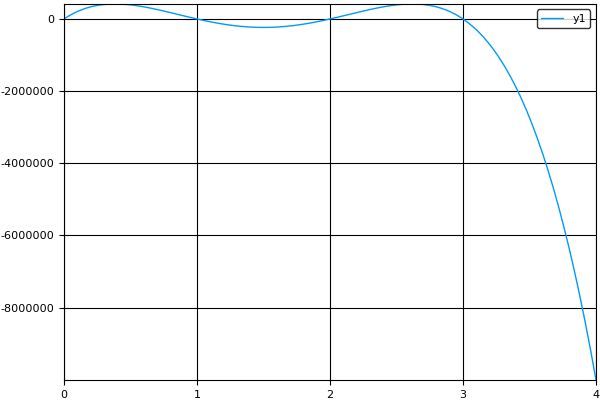

In [253]:
plot(linspace(0,4,100),interpolantfunc2(linspace(0,4,100)))

In [258]:
interpolantfunc = LagrangeInterpolantGenerator([1.0,2.0,3.0,4.0],[4.0,2.0,8.0,0.0])
interpolantfunc(2.0)   #returns 2.0
interpolantfunc(3.0)   #returns 8.0
interpolantfunc(2.5)   #returns 5.375

5.375